In [ ]:
import os
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torch.utils.data import Dataset
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy
import mne

In [4]:
data = r"/Users/josephthi/Desktop/UCI_Classes/cs184A/CS_184A_Final Project/data/spectrogram_data"

In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [6]:
def append_data(path):
    X_data = []
    y_data = []
    for data in sorted(os.listdir(path)):
        file_path = os.path.join(path, data)
        if 'X' in data:
            X = np.load(file_path)
            X_data.append(X)
        elif 'y' in data:
            y = np.load(file_path)
            y_data.append(y)
        
    return X_data, y_data

In [7]:
X_data, y_data = append_data(r"data/spectrogram_data")
# X_data_n, y_data_n = append_data(r"data/noisy_spectrogram_data") 

# --- Subject-level split (avoids data leakage) ---
# Each element of X_data/y_data corresponds to one subject
subject_ids = np.arange(len(X_data))
subject_labels = np.array([y[0] for y in y_data])  # get label from first epoch of each subject

# First split: train vs temp
train_ids, temp_ids = train_test_split(
    subject_ids,
    test_size=0.30,
    stratify=subject_labels,   # stratify by subject label
    random_state=42
)

# Second split: val vs test (50/50 of the temp set)
val_ids, test_ids = train_test_split(
    temp_ids,
    test_size=0.50,
    stratify=subject_labels[temp_ids],
    random_state=42
)

print(f"Subject-level split:")
print(f"  Train: {len(train_ids)} subjects")
print(f"  Val:   {len(val_ids)} subjects")
print(f"  Test:  {len(test_ids)} subjects")

# Concatenate all epochs for each split
X_train = np.concatenate([X_data[i] for i in train_ids], axis=0)
y_train = np.concatenate([y_data[i] for i in train_ids], axis=0)

X_val = np.concatenate([X_data[i] for i in val_ids], axis=0)
y_val = np.concatenate([y_data[i] for i in val_ids], axis=0)

X_test = np.concatenate([X_data[i] for i in test_ids], axis=0)
y_test = np.concatenate([y_data[i] for i in test_ids], axis=0)

print(f"Epoch counts after concatenation:")
print(f"  Train: {len(X_train)} epochs")
print(f"  Val:   {len(X_val)} epochs")
print(f"  Test:  {len(X_test)} epochs")


Subject-level split:
  Train: 61 subjects
  Val:   13 subjects
  Test:  14 subjects
Epoch counts after concatenation:
  Train: 47064 epochs
  Val:   10511 epochs
  Test:  12130 epochs
Epoch counts after concatenation:
  Train: 47064 epochs
  Val:   10511 epochs
  Test:  12130 epochs


In [8]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        super(EEGDataset, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
# --- Per-sample normalization (normalize each epoch independently) ---
# This normalizes each sample to zero-mean, unit-variance across all channels/freq/time
eps = 1e-8

for i in range(X_train.shape[0]):
    m = X_train[i].mean()
    s = X_train[i].std()
    X_train[i] = (X_train[i] - m) / (s + eps)

for i in range(X_val.shape[0]):
    m = X_val[i].mean()
    s = X_val[i].std()
    X_val[i] = (X_val[i] - m) / (s + eps)

for i in range(X_test.shape[0]):
    m = X_test[i].mean()
    s = X_test[i].std()
    X_test[i] = (X_test[i] - m) / (s + eps)

print(f"\nPer-sample normalization complete")
print(f"  Train X: mean={X_train.mean():.3e}, std={X_train.std():.3e}")
print(f"  Val X:   mean={X_val.mean():.3e}, std={X_val.std():.3e}")
print(f"  Test X:  mean={X_test.mean():.3e}, std={X_test.std():.3e}")

# Create datasets and dataloaders
train_dataset = EEGDataset(X_train, y_train)
val_dataset   = EEGDataset(X_val, y_val)
test_dataset  = EEGDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=32, shuffle=False)


Per-sample normalization complete
  Train X: mean=-1.013e-22, std=1.426e-03
  Val X:   mean=-5.672e-23, std=1.455e-03
  Train X: mean=-1.013e-22, std=1.426e-03
  Val X:   mean=-5.672e-23, std=1.455e-03
  Test X:  mean=1.085e-22, std=1.223e-03
  Test X:  mean=1.085e-22, std=1.223e-03


In [10]:
print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (47064, 19, 33, 7), Val shape: (10511, 19, 33, 7), Test shape: (12130, 19, 33, 7)


In [51]:
model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
model = model.to(device)

# Freeze backbone layers initially to leverage pretrained features
for param in model.features.parameters():
    param.requires_grad = False

# Update input channels from 3 to 19 for EEG spectrograms
model.features[0][0] = nn.Conv2d(
    in_channels=19,
    out_channels=32,
    kernel_size=(3, 3),
    stride=(2, 2),
    padding=(1, 1),
    bias=False
).to(device)

# Unfreeze the first conv layer since we changed its input channels
for param in model.features[0][0].parameters():
    param.requires_grad = True

# Unfreeze the last 3 feature modules to allow fine-tuning of high-level features
num_unfreeze = 3
features_list = list(model.features)
if num_unfreeze > 0:
    for idx, module in enumerate(features_list[-num_unfreeze:]):
        for param in module.parameters():
            param.requires_grad = True

# Replace final classifier with Dropout + Linear to output 3 classes
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, 3)
).to(device)

# Ensure classifier parameters are trainable
for param in model.classifier.parameters():
    param.requires_grad = True

print("Model initialized with:")
print(f"  - Frozen backbone except: first conv + last {num_unfreeze} feature modules")
print("  - Trainable classifier with dropout (p=0.5)")
print("Unfrozen feature module indices:", list(range(len(features_list)-num_unfreeze, len(features_list))))

Model initialized with:
  - Frozen backbone except: first conv + last 3 feature modules
  - Trainable classifier with dropout (p=0.5)
Unfrozen feature module indices: [16, 17, 18]


In [52]:
# Calculate class weights based on training set distribution
unique_y_train, counts_y_train = np.unique(y_train, return_counts=True)
total_train = len(y_train)
class_weights_dict = {label: total_train / (count + 1e-8) for label, count in zip(unique_y_train, counts_y_train)}

print(f"\nClass distribution in training set:")
for label, count in zip(unique_y_train, counts_y_train):
    print(f"  Label {label}: {count} epochs ({100*count/total_train:.1f}%)")

# Create weight tensor: weights[i] is the weight for class i
weights_list = [class_weights_dict.get(i, 1.0) for i in range(3)]
weights = torch.tensor(weights_list, dtype=torch.float32)
print(f"\nClass weights: {weights.numpy()}")

# Use class weights to mitigate class imbalance
weights = weights.to(device)
criterion = nn.CrossEntropyLoss(weight=weights)


Class distribution in training set:
  Label 0: 11373 epochs (24.2%)
  Label 1: 19315 epochs (41.0%)
  Label 2: 16376 epochs (34.8%)

Class weights: [4.138222  2.4366555 2.873962 ]


In [53]:
# Initialize lists to track metrics per epoch
train_losses = []
train_accs = []
val_losses = []
val_accs = []


In [46]:
num_epochs = 50
learning_rate = 1e-4
l2_lambda = 1e-5  # L2 regularization strength (weight decay)
# Only optimize parameters that require gradients (conv1 + fc)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=l2_lambda)

In [54]:
best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    
    # ------- TRAIN -------
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)

        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, preds = outputs.max(1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)

    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # ------- VALIDATION -------
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            val_loss += loss.item()
            _, preds = outputs.max(1)

            val_correct += (preds == batch_y).sum().item()
            val_total += batch_y.size(0)

    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"mobilenet_checkpoints/best_model_{best_val_acc}.pth")
        print("Saved new best model!")

    # ------- PRINT METRICS -------
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Val Acc (smooth): {0.7*val_acc + 0.3*best_val_acc:.4f}")


Epoch [1/50]
Saved new best model!
Train Loss: 1709.1177, Train Acc: 0.3297
Val Loss: 373.5888, Val Acc: 0.3305
Val Acc (smooth): 0.3305

Epoch [2/50]
Saved new best model!
Train Loss: 1709.1177, Train Acc: 0.3297
Val Loss: 373.5888, Val Acc: 0.3305
Val Acc (smooth): 0.3305

Epoch [2/50]
Train Loss: 1707.8543, Train Acc: 0.3334
Val Loss: 375.0357, Val Acc: 0.3209
Val Acc (smooth): 0.3238

Epoch [3/50]
Train Loss: 1707.8543, Train Acc: 0.3334
Val Loss: 375.0357, Val Acc: 0.3209
Val Acc (smooth): 0.3238

Epoch [3/50]
Train Loss: 1713.8271, Train Acc: 0.3265
Val Loss: 374.5407, Val Acc: 0.3063
Val Acc (smooth): 0.3135

Epoch [4/50]
Train Loss: 1713.8271, Train Acc: 0.3265
Val Loss: 374.5407, Val Acc: 0.3063
Val Acc (smooth): 0.3135

Epoch [4/50]
Train Loss: 1714.9097, Train Acc: 0.3266
Val Loss: 372.5003, Val Acc: 0.3297
Val Acc (smooth): 0.3300

Epoch [5/50]
Train Loss: 1714.9097, Train Acc: 0.3266
Val Loss: 372.5003, Val Acc: 0.3297
Val Acc (smooth): 0.3300

Epoch [5/50]
Train Loss: 17

In [55]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 32.47%


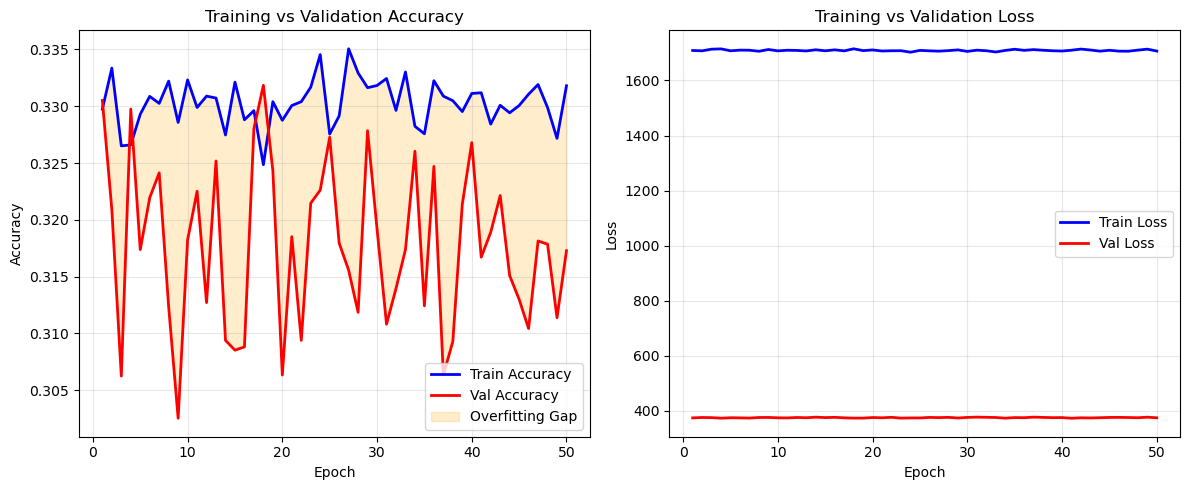


Overfitting Analysis:
  Final Train Acc: 0.3318
  Final Val Acc:   0.3173
  Overfitting Gap: 0.0145


In [56]:
# Plot training vs validation accuracy to visualize overfitting
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
epochs_range = range(1, len(train_accs) + 1)
plt.plot(epochs_range, train_accs, 'b-', label='Train Accuracy', linewidth=2)
plt.plot(epochs_range, val_accs, 'r-', label='Val Accuracy', linewidth=2)
plt.fill_between(epochs_range, train_accs, val_accs, alpha=0.2, color='orange', label='Overfitting Gap')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2)
plt.plot(epochs_range, val_losses, 'r-', label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOverfitting Analysis:")
print(f"  Final Train Acc: {train_accs[-1]:.4f}")
print(f"  Final Val Acc:   {val_accs[-1]:.4f}")
print(f"  Overfitting Gap: {train_accs[-1] - val_accs[-1]:.4f}")


Test Accuracy: 39.79%

Confusion Matrix:
 [[ 861  827  735]
 [2331 2251  992]
 [1000 1419 1714]]


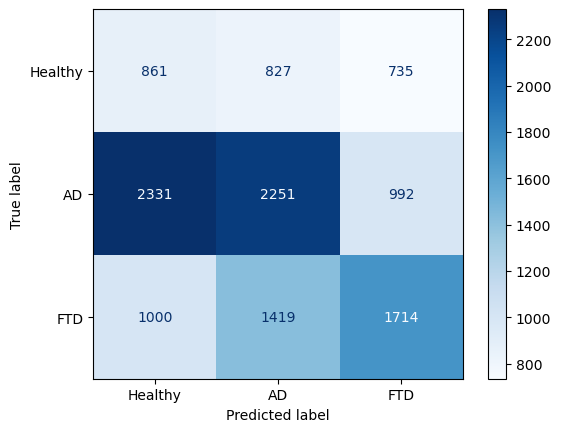

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.21      0.36      0.26      2423
          AD       0.50      0.40      0.45      5574
         FTD       0.50      0.41      0.45      4133

    accuracy                           0.40     12130
   macro avg       0.40      0.39      0.39     12130
weighted avg       0.44      0.40      0.41     12130



In [50]:
# Make sure model is in evaluation mode
model.eval()

all_preds = []
all_labels = []

# Disable gradients for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.append(predicted.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Flatten lists
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# --- Accuracy ---
accuracy = (all_preds == all_labels).mean()
print(f"Test Accuracy: {accuracy*100:.2f}%\n")

# --- Confusion Matrix ---
# Labels encoding: 0=Healthy, 1=Alzheimer (AD), 2=FTD
class_names = ["Healthy", "AD", "FTD"]
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# --- Precision, Recall, F1 ---
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n", report)